In [2]:
!mkdir ./data/
!gsutil cp -r gs://lg_inconvenience/data.zip ./data/
!unzip ./data/data.zip -d ./data/

Copying gs://lg_inconvenience/data.zip...
\ [1 files][133.4 MiB/133.4 MiB]                                                
Operation completed over 1 objects/133.4 MiB.                                    
Archive:  ./data/data.zip
  inflating: ./data/sample_submission.csv  
  inflating: ./data/test_err_data.csv  
  inflating: ./data/test_quality_data.csv  
  inflating: ./data/train_err_data.csv  
  inflating: ./data/train_problem_data.csv  
  inflating: ./data/train_quality_data.csv  


In [3]:
!pip install pycaret
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = './data/'

     |████████████████████████████████| 256kB 6.5MB/s 
     |████████████████████████████████| 6.8MB 8.8MB/s 
     |████████████████████████████████| 1.6MB 64.7MB/s 
     |████████████████████████████████| 245kB 58.3MB/s 
     |████████████████████████████████| 14.2MB 60.9MB/s 
     |████████████████████████████████| 65.8MB 107kB/s 
     |████████████████████████████████| 157.5MB 43kB/s 
     |████████████████████████████████| 174kB 63.2MB/s 
     |████████████████████████████████| 276kB 63.4MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 1.8MB 58.8MB/s 
     |████████████████████████████████| 604kB 60.1MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 3.1MB 65.2MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 1.1MB 65.2MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 

#quaility데이터는 근방시간에 err가 많은 순으로 가중치를 주어서 유저당 하나의 row를 만들도록 하자

In [4]:
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')
# display(train_err.head())

In [5]:
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


In [6]:
#
len(train_quality.user_id.unique())

8281

In [7]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_err.user_id.unique()

array([10000, 10001, 10002, ..., 24997, 24998, 24999])

In [8]:
len(train_err.user_id.unique())

15000

##퀄리티 데이터가 있는 유저가 8281명 없는 유저가 6719명 없는 유저들중 1인 유저가 1833명이다. 

퀄리티데이터가 없는 유저들은 우선 결측치로 두고 평균으로 채우던지 0으로 채우던지 하자

In [9]:
train_quality  = pd.read_csv(PATH+'train_quality_data.csv')

In [10]:
len(train_quality.user_id.unique())

8281

###결측치 포함 행은 제거하기 

In [11]:
train_quality = train_quality.dropna()

In [12]:
len(train_quality.user_id.unique())

7727

In [13]:
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
1,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
2,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
3,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
4,20201129090000,10000,05.15.2138,0.0,0,0.0,0,0,0,0,0,0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,1,0,0,0,0,17,0,0
828620,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0
828621,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,3,0,0,0,0,17,0,0
828622,20201124033000,24997,04.22.1778,0.0,0,0.0,0,0,0,0,0,0,0,17,0,0


###모든 quaility열을 float로 바꾸기

In [14]:
for col in train_quality.columns[3:] : 
  q_list = []
  for q in train_quality[col] : 
    try :
      q_list.append( float(q) )
    except : 
      q_list.append( float( q.replace(',','') ) )
  train_quality[col] = q_list

In [15]:
train_quality

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
1,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
3,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,20201129090000,10000,05.15.2138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828619,20201124033000,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828620,20201124033000,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828621,20201124033000,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0
828622,20201124033000,24997,04.22.1778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0


In [16]:
selected_quality_df = pd.DataFrame(columns =['user_id', 'quality_0', 'quality_1', 'quality_2', 'quality_3',
       'quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8',
       'quality_9', 'quality_10', 'quality_11', 'quality_12'] )

In [17]:
uid_list_qual = train_quality.user_id.unique()
uid_list_qual

array([10000, 10002, 10004, ..., 24993, 24995, 24997])

In [18]:
for uid in uid_list_qual : 
  df_qual = train_quality[train_quality.user_id == uid]
  df_qual_mean = df_qual.groupby(df_qual['time']).mean()

  df_err = train_err[train_err.user_id == uid]
  df_err_groupby_etcount = df_err.groupby(df_err['time']).count()['errtype']
  # print()

  idx_etcount_bytime = df_err_groupby_etcount.keys()
  value_etcount_bytime = df_err_groupby_etcount.values

  time_weight_list = []
  for time in df_qual_mean.index :
    dff_lst = []
    for t in idx_etcount_bytime : 
      dff_lst.append( abs(t - time) )
    
    near_idx = dff_lst.index(min(dff_lst))

    weigths = value_etcount_bytime[near_idx-5 : near_idx+5] # 앞에 5개가 다는 없을지도. 뒤에 5개도 다는 없을지도. 
    time_weight_list.append(weigths.mean())
    # print(time_weight_list)
    # print(near_idx," ",time,"의 가중치는 ", weigths.mean() )

  selected_row_idx = time_weight_list.index( max(time_weight_list) )
  selected_quality_df = selected_quality_df.append(
       df_qual_mean.iloc[selected_row_idx]
  )



  # break

In [19]:
selected_quality_df

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
20201129090000,10000.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,4.0,0.000000,0.0
20201111010000,10002.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.166667,2.0,0.0,0.0,4.0,0.000000,0.0
20201102232000,10004.0,-0.166667,-0.166667,-0.166667,0.0,0.0,0.083333,-0.166667,0.0,0.0,0.0,3.0,-0.166667,0.0
20201119040000,10005.0,-0.833333,-0.833333,-0.833333,0.0,0.0,-0.500000,2.166667,36.0,0.0,0.0,4.0,-0.833333,0.0
20201109215000,10006.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.333333,4.0,0.0,0.0,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201123184000,24986.0,0.000000,0.000000,0.000000,0.0,0.0,14.916667,0.000000,0.0,0.0,0.0,179.0,0.000000,0.0
20201109110000,24992.0,-0.750000,-0.750000,-0.750000,0.0,0.0,-0.250000,-0.750000,0.0,0.0,0.0,6.0,-0.750000,0.0
20201101131000,24993.0,-0.333333,-0.333333,-0.333333,0.0,0.0,-0.083333,-0.333333,0.0,0.0,0.0,3.0,-0.333333,0.0
20201128202000,24995.0,-0.666667,-0.666667,-0.666667,0.0,0.0,-0.500000,-0.666667,0.0,0.0,0.0,2.0,-0.666667,0.0


In [20]:
selected_quality_df.dropna()

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
20201129090000,10000.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,4.0,0.000000,0.0
20201111010000,10002.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.166667,2.0,0.0,0.0,4.0,0.000000,0.0
20201102232000,10004.0,-0.166667,-0.166667,-0.166667,0.0,0.0,0.083333,-0.166667,0.0,0.0,0.0,3.0,-0.166667,0.0
20201119040000,10005.0,-0.833333,-0.833333,-0.833333,0.0,0.0,-0.500000,2.166667,36.0,0.0,0.0,4.0,-0.833333,0.0
20201109215000,10006.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.333333,4.0,0.0,0.0,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201123184000,24986.0,0.000000,0.000000,0.000000,0.0,0.0,14.916667,0.000000,0.0,0.0,0.0,179.0,0.000000,0.0
20201109110000,24992.0,-0.750000,-0.750000,-0.750000,0.0,0.0,-0.250000,-0.750000,0.0,0.0,0.0,6.0,-0.750000,0.0
20201101131000,24993.0,-0.333333,-0.333333,-0.333333,0.0,0.0,-0.083333,-0.333333,0.0,0.0,0.0,3.0,-0.333333,0.0
20201128202000,24995.0,-0.666667,-0.666667,-0.666667,0.0,0.0,-0.500000,-0.666667,0.0,0.0,0.0,2.0,-0.666667,0.0


#quaility_data가 있는 유저를 예측하는 모델

In [21]:
selected_quality_df.user_id

20201129090000    10000.0
20201111010000    10002.0
20201102232000    10004.0
20201119040000    10005.0
20201109215000    10006.0
                   ...   
20201123184000    24986.0
20201109110000    24992.0
20201101131000    24993.0
20201128202000    24995.0
20201108230000    24997.0
Name: user_id, Length: 7727, dtype: float64

7727명에 대한 모델을 만들어보자

In [22]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')

In [23]:
uid_list = selected_quality_df.user_id.unique()

In [24]:
uid_list

array([10000., 10002., 10004., ..., 24993., 24995., 24997.])

In [25]:
train_err.user_id

0           10000
1           10000
2           10000
3           10000
4           10000
            ...  
16554658    24999
16554659    24999
16554660    24999
16554661    24999
16554662    24999
Name: user_id, Length: 16554663, dtype: int64

In [26]:
true_lst = []
for uid in train_err.user_id :
  if uid in uid_list : 
    true_lst.append(True)
  else : 
    true_lst.append(False)


In [27]:
train_err[true_lst]

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16553933,24997,20201130124418,model_0,04.22.1778,15,1
16553934,24997,20201130170055,model_0,04.22.1778,16,1
16553935,24997,20201130170056,model_0,04.22.1778,31,1
16553936,24997,20201130170108,model_0,04.22.1778,31,0


In [28]:
len(uid_list)

7727

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_err = train_err[true_lst]

#Errtype count로 Feature 42개 생성

In [29]:
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

100%|██████████| 9449360/9449360 [00:26<00:00, 362623.59it/s]


In [1]:
id_error

NameError: ignored

##95%를 포함하는 에러코드 10개 선택

In [30]:
errcodes_selected_ratio = {'0': 0.15700247114664914,
 '1': 0.5380337249994156,
 '14': 0.01592161676743284,
 '2': 0.010050461311112162,
 '79': 0.020080263790329046,
 '80': 0.020176671672507016,
 '84': 0.007845282021144134,
 'B-A8002': 0.05423625959646536,
 'active': 0.013243277739933456,
 'connection timeout': 0.1108811456929084}

In [31]:
errcodes_selected =['1',
 '0',
 'connection timeout',
 'B-A8002',
 '80',
 '79',
 '14',
 'active',
 '2',
 '84']

#ErrCode ratio로  Feature 10개 생성

In [32]:
id_ec = train_err[['user_id','errcode']].values
ecs = np.zeros((15000,10))
for person_idx, ec in tqdm(id_ec):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if ec in errcodes_selected : 
      ecs[ person_idx - 10000 , errcodes_selected.index(ec) ] = errcodes_selected_ratio[ec]

100%|██████████| 9449360/9449360 [00:16<00:00, 556595.07it/s]


# model_nm으로 feature 9개 생성

In [33]:
id_mn = train_err[['user_id','model_nm']].values
mns = np.zeros((15000,9))
pre_person_idx = 10000


def make_dict() : 
  dicts = [i for i in range(0,9)]
  for i in range(0,9) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, mn in tqdm(id_mn):
  if person_idx == pre_person_idx : 
    dicts[ int(mn.split("_")[1]) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,9) : 
      mns[pre_person_idx -10000, index] = dicts[index] / sum_dicts(dicts)
    dicts = make_dict()
    pre_person_idx = person_idx

    dicts[ int(mn.split("_")[1]) ] +=1


100%|██████████| 9449360/9449360 [00:18<00:00, 523259.80it/s]


#fwver ratio로 feature 7개 생성

In [35]:
fwvers_selected = []
fwvers_selected_ratio = {}
count = 0 
value_count = train_err.fwver.value_counts()
for fwver in value_count.keys() : 
  count += value_count[fwver]
  if count/9449360 > 0.99 :
    break
  else : 
    fwvers_selected.append(fwver)
    fwvers_selected_ratio[fwver] = value_count[fwver]/9449360

In [36]:
fwvers_selected

['04.16.3553',
 '04.22.1750',
 '04.33.1261',
 '05.15.2138',
 '04.22.1778',
 '04.33.1185',
 '04.16.3571']

In [37]:
id_fwver = train_err[['user_id','fwver']].values
fwvers = np.zeros((15000,7))
for person_idx, fwver in tqdm(id_fwver):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if fwver in fwvers_selected : 
      fwvers[ person_idx - 10000 , fwvers_selected.index(fwver) ] = fwvers_selected_ratio[fwver]

100%|██████████| 9449360/9449360 [00:18<00:00, 524793.96it/s]


#errtyp4, 31 여부

In [38]:
id_error = train_err[['user_id','errtype']].values
et_4_31 = np.zeros((15000,2))
for person_idx, err in tqdm(id_error):
  if err == 4 : 
    et_4_31[person_idx - 10000, 0] = 1
  elif err == 31:
    et_4_31[person_idx - 10000, 1] = 1


100%|██████████| 9449360/9449360 [00:19<00:00, 493063.14it/s]


In [92]:
selected_quality_df

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
20201129090000,10000.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,4.0,0.000000,0.0
20201111010000,10002.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.166667,2.0,0.0,0.0,4.0,0.000000,0.0
20201102232000,10004.0,-0.166667,-0.166667,-0.166667,0.0,0.0,0.083333,-0.166667,0.0,0.0,0.0,3.0,-0.166667,0.0
20201119040000,10005.0,-0.833333,-0.833333,-0.833333,0.0,0.0,-0.500000,2.166667,36.0,0.0,0.0,4.0,-0.833333,0.0
20201109215000,10006.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.333333,4.0,0.0,0.0,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201123184000,24986.0,0.000000,0.000000,0.000000,0.0,0.0,14.916667,0.000000,0.0,0.0,0.0,179.0,0.000000,0.0
20201109110000,24992.0,-0.750000,-0.750000,-0.750000,0.0,0.0,-0.250000,-0.750000,0.0,0.0,0.0,6.0,-0.750000,0.0
20201101131000,24993.0,-0.333333,-0.333333,-0.333333,0.0,0.0,-0.083333,-0.333333,0.0,0.0,0.0,3.0,-0.333333,0.0
20201128202000,24995.0,-0.666667,-0.666667,-0.666667,0.0,0.0,-0.500000,-0.666667,0.0,0.0,0.0,2.0,-0.666667,0.0


In [43]:
train_err.user_id.unique()

array([10000, 10002, 10004, ..., 24993, 24995, 24997])

In [45]:
all_uids = pd.read_csv(PATH+'train_err_data.csv').user_id.unique()

In [46]:
len(all_uids)

15000

In [ ]:
all_uids

In [110]:
truid_list = train_err.user_id.unique()

In [111]:
truid_list.shape

(7727,)

In [56]:
print(sorted(all_uids) )

[10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142

In [54]:
uid_lst_true = []
for uid in sorted(all_uids) : 
  if uid in truid_list : 
    uid_lst_true.append(True)
  else :
    uid_lst_true.append(False)


In [ ]:
uid_lst_true

In [61]:
len(uid_lst_true)

15000

In [62]:
error[uid_lst_true]

array([[ 0.,  0.,  8., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  4.,  0.,  2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  9.,  7.,  4.],
       [ 0.,  0.,  0., ..., 58.,  8.,  5.]])

In [66]:
selected_quality_df

,user_id,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
20201129090000,10000.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,4.0,0.000000,0.0
20201111010000,10002.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.166667,2.0,0.0,0.0,4.0,0.000000,0.0
20201102232000,10004.0,-0.166667,-0.166667,-0.166667,0.0,0.0,0.083333,-0.166667,0.0,0.0,0.0,3.0,-0.166667,0.0
20201119040000,10005.0,-0.833333,-0.833333,-0.833333,0.0,0.0,-0.500000,2.166667,36.0,0.0,0.0,4.0,-0.833333,0.0
20201109215000,10006.0,0.000000,0.000000,0.000000,0.0,0.0,0.333333,0.333333,4.0,0.0,0.0,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201123184000,24986.0,0.000000,0.000000,0.000000,0.0,0.0,14.916667,0.000000,0.0,0.0,0.0,179.0,0.000000,0.0
20201109110000,24992.0,-0.750000,-0.750000,-0.750000,0.0,0.0,-0.250000,-0.750000,0.0,0.0,0.0,6.0,-0.750000,0.0
20201101131000,24993.0,-0.333333,-0.333333,-0.333333,0.0,0.0,-0.083333,-0.333333,0.0,0.0,0.0,3.0,-0.333333,0.0
20201128202000,24995.0,-0.666667,-0.666667,-0.666667,0.0,0.0,-0.500000,-0.666667,0.0,0.0,0.0,2.0,-0.666667,0.0


In [72]:
selected_quality_df.drop("user_id",axis = 1).to_numpy()

array([[ 0.        ,  0.        ,  0.        , ...,  4.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  4.        ,
         0.        ,  0.        ],
       [-0.16666667, -0.16666667, -0.16666667, ...,  3.        ,
        -0.16666667,  0.        ],
       ...,
       [-0.33333333, -0.33333333, -0.33333333, ...,  3.        ,
        -0.33333333,  0.        ],
       [-0.66666667, -0.66666667, -0.66666667, ...,  2.        ,
        -0.66666667,  0.        ],
       [-0.33333333, -0.33333333, -0.33333333, ...,  2.        ,
        -0.33333333,  0.        ]])

In [74]:
# error = error[uid_lst_true]
ecs = ecs[uid_lst_true]
mns = mns[uid_lst_true]
fwvers = fwvers[uid_lst_true]
et_4_31 = et_4_31[uid_lst_true]

IndexError: ignored

In [78]:
fwvers

(7727, 7)

In [79]:
train = np.concatenate( (error,ecs, mns,fwvers ,et_4_31, selected_quality_df.drop("user_id",axis = 1).to_numpy() ) , axis=1) 

In [87]:
train

array([[ 0.        ,  0.        ,  8.        , ...,  4.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  2.        , ...,  4.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  3.        ,
        -0.16666667,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.        ,
        -0.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  2.        ,
        -0.66666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  2.        ,
        -0.33333333,  0.        ]])

In [88]:
train = pd.DataFrame(train)
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

train['problem'] = problem[uid_lst_true]
from pycaret.classification import *
clf = setup(data = train, target = 'problem') 

,Description,Value
0,session_id,6340
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(7727, 84)"
5,Missing Values,False
6,Numeric Features,64
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


In [89]:
best_5 = compare_models(sort = 'AUC', n_select = 5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7559,0.7961,0.5307,0.7824,0.6313,0.4591,0.4790,5.888
gbc,Gradient Boosting Classifier,0.7613,0.7948,0.5148,0.8130,0.6291,0.4664,0.4934,0.226
rf,Random Forest Classifier,0.7463,0.7833,0.5143,0.7667,0.6150,0.4369,0.4565,0.163
ada,Ada Boost Classifier,0.7491,0.7807,0.5236,0.7683,0.6223,0.4445,0.4631,0.069
lightgbm,Light Gradient Boosting Machine,0.7496,0.7767,0.5541,0.7478,0.6357,0.4516,0.4638,0.191
et,Extra Trees Classifier,0.7507,0.7732,0.5320,0.7658,0.6276,0.4494,0.4663,0.152
xgboost,Extreme Gradient Boosting,0.7435,0.7669,0.5676,0.7242,0.6357,0.4425,0.4507,49.269
lda,Linear Discriminant Analysis,0.7311,0.7479,0.4038,0.8294,0.5424,0.3827,0.4329,0.029
qda,Quadratic Discriminant Analysis,0.7217,0.7276,0.4965,0.7196,0.5845,0.3860,0.4031,0.022
lr,Logistic Regression,0.7045,0.7268,0.4053,0.7248,0.5187,0.3302,0.3594,0.431


In [90]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7458,0.7591,0.5093,0.7703,0.6132,0.4354,0.4561
1,0.7542,0.7959,0.5187,0.7872,0.6254,0.4537,0.4756
2,0.7754,0.8139,0.5363,0.8358,0.6534,0.4987,0.5256
3,0.7715,0.7846,0.5714,0.7922,0.6639,0.4976,0.5129
4,0.7567,0.8014,0.5340,0.7808,0.6342,0.4614,0.4801
Mean,0.7607,0.7910,0.5339,0.7933,0.6380,0.4694,0.4901
SD,0.0111,0.0185,0.0212,0.0225,0.0184,0.0250,0.0255


In [91]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7611,0.8003,0.5453,0.7931,0.6462,0.4751,0.4941


In [126]:
final_model = finalize_model(blended)

#테스트셋 만들기

In [119]:
test_quality  = pd.read_csv(PATH+'test_quality_data.csv')
test_err  = pd.read_csv(PATH+'test_err_data.csv')
#결측치 포함 행 제거하기
test_quality = test_quality.dropna()
#모든 quaility열을 float로 바꾸기
for col in test_quality.columns[3:] : 
  q_list = []
  for q in test_quality[col] : 
    try :
      q_list.append( float(q) )
    except : 
      q_list.append( float( q.replace(',','') ) )
  test_quality[col] = q_list

  selected_quality_df = pd.DataFrame(columns =['user_id', 'quality_0', 'quality_1', 'quality_2', 'quality_3',
       'quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8',
       'quality_9', 'quality_10', 'quality_11', 'quality_12'] )

uid_list_qual = test_quality.user_id.unique()


for uid in uid_list_qual : 
  df_qual = test_quality[test_quality.user_id == uid]
  df_qual_mean = df_qual.groupby(df_qual['time']).mean()

  df_err = test_err[test_err.user_id == uid]
  df_err_groupby_etcount = df_err.groupby(df_err['time']).count()['errtype']
  # print()

  idx_etcount_bytime = df_err_groupby_etcount.keys()
  value_etcount_bytime = df_err_groupby_etcount.values

  time_weight_list = []
  for time in df_qual_mean.index :
    dff_lst = []
    for t in idx_etcount_bytime : 
      dff_lst.append( abs(t - time) )
    
    near_idx = dff_lst.index(min(dff_lst))

    weigths = value_etcount_bytime[near_idx-5 : near_idx+5] # 앞에 5개가 다는 없을지도. 뒤에 5개도 다는 없을지도. 
    time_weight_list.append(weigths.mean())
    # print(time_weight_list)
    # print(near_idx," ",time,"의 가중치는 ", weigths.mean() )

  selected_row_idx = time_weight_list.index( max(time_weight_list) )
  selected_quality_df = selected_quality_df.append(
       df_qual_mean.iloc[selected_row_idx]
  )

  # break

uid_list = selected_quality_df.user_id.unique()
true_lst = []
for uid in test_err.user_id :
  if uid in uid_list : 
    true_lst.append(True)
  else : 
    true_lst.append(False)


#Errtype count로 Feature 42개 생성
id_error = test_err[['user_id','errtype']].values
error = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 30000,err - 1] += 1

#95%를 포함하는 에러코드 10개 선택
errcodes_selected_ratio = {'0': 0.15700247114664914,
 '1': 0.5380337249994156,
 '14': 0.01592161676743284,
 '2': 0.010050461311112162,
 '79': 0.020080263790329046,
 '80': 0.020176671672507016,
 '84': 0.007845282021144134,
 'B-A8002': 0.05423625959646536,
 'active': 0.013243277739933456,
 'connection timeout': 0.1108811456929084}

errcodes_selected =['1',
'0',
'connection timeout',
'B-A8002',
'80',
'79',
'14',
'active',
'2',
'84']

#ErrCode ratio로 Feature 10개 생성
id_ec = test_err[['user_id','errcode']].values
ecs = np.zeros((14999,10))
for person_idx, ec in tqdm(id_ec):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if ec in errcodes_selected : 
      ecs[ person_idx - 30000 , errcodes_selected.index(ec) ] = errcodes_selected_ratio[ec]

#model_nm으로 feature 9개 생성
id_mn = test_err[['user_id','model_nm']].values
mns = np.zeros((14999,9))
pre_person_idx = 30000


def make_dict() : 
  dicts = [i for i in range(0,9)]
  for i in range(0,9) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, mn in tqdm(id_mn):
  if person_idx == pre_person_idx : 
    dicts[ int(mn.split("_")[1]) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,9) : 
      mns[pre_person_idx -30000, index] = dicts[index] / sum_dicts(dicts)
    dicts = make_dict()
    pre_person_idx = person_idx

    dicts[ int(mn.split("_")[1]) ] +=1

#fwver ratio로 feature 7개 생성
fwvers_selected = []
fwvers_selected_ratio = {}
count = 0 
value_count = test_err.fwver.value_counts()
for fwver in value_count.keys() : 
  count += value_count[fwver]
  if count/9449360 > 0.99 :
    break
  else : 
    fwvers_selected.append(fwver)
    fwvers_selected_ratio[fwver] = value_count[fwver]/9449360

id_fwver = test_err[['user_id','fwver']].values
fwvers = np.zeros((14999,7))
for person_idx, fwver in tqdm(id_fwver):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if fwver in fwvers_selected : 
      fwvers[ person_idx - 30000 , fwvers_selected.index(fwver) ] = fwvers_selected_ratio[fwver]

#errtyp4, 31 여부
id_error = test_err[['user_id','errtype']].values
et_4_31 = np.zeros((14999,2))
for person_idx, err in tqdm(id_error):
  if err == 4 : 
    et_4_31[person_idx - 30000, 0] = 1
  elif err == 31:
    et_4_31[person_idx - 30000, 1] = 1



100%|██████████| 16532648/16532648 [00:32<00:00, 507221.96it/s]


In [123]:
ecs.shape

(7717, 10)

In [120]:
all_uids = []
for i in range(30000,44998+1) : 
  all_uids.append(i)
truid_list = test_quality.user_id.unique()
uid_lst_true = []
for uid in sorted(all_uids) : 
  if uid in truid_list : 
    uid_lst_true.append(True)
  else :
    uid_lst_true.append(False)

error = error[uid_lst_true]
ecs = ecs[uid_lst_true]
mns = mns[uid_lst_true]
fwvers = fwvers[uid_lst_true]
et_4_31 = et_4_31[uid_lst_true]

test = np.concatenate( (error,ecs, mns,fwvers ,et_4_31, selected_quality_df.drop("user_id",axis = 1).to_numpy() ) , axis=1) 

test = pd.DataFrame(test)

In [127]:
predictions = predict_model(final_model, data = test)

In [128]:
#pycaret prediction에서 Label은 '0', '1', 'Score'은 Label을 맞출 확률이기
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])

In [138]:
len(x)

7717

In [144]:
sample_submssion = pd.read_csv('/content/70features.csv')
# sample_submssion['problem'] = x
# sample_submssion.to_csv("70features.csv", index = False)

In [145]:
new_problem = []
index = 0 
for i, row in sample_submssion.iterrows() : 
  if row[0] in truid_list : 
    new_problem.append(x[index])
    index+=1
  else : 
    new_problem.append(row[1])


In [146]:
sample_submssion['problem'] = new_problem

In [149]:
sample_submssion.to_csv("70_and_qual_features.csv", index=False)

In [139]:
truid_list

array([30000, 30001, 30002, ..., 44994, 44996, 44997])

In [134]:
len(truid_list)

7717

In [ ]:
predictions

In [118]:
error.shape

(14998, 42)

In [115]:
len(test_quality.user_id.unique())

7717

In [109]:
len(truid_list)

14998

In [107]:
error[uid_lst_true]

IndexError: ignored

In [104]:
all_uids = []
for i in range(30000,44998+1) : 
  all_uids.append(i)
all_uids[-1]

44998

In [100]:
person_idx-30000

14998

In [ ]:
pd.read_csv(PATH+'test_err_data.csv')

In [97]:
len(all_uids)

14998

In [95]:
uid_lst_true

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

#test_quaility에 대해서도 알아보자


In [113]:
for uid in uid_list_qual : 
  df = train_err[train_err.user_id == uid]
  df.groupby(df['time'])
  break


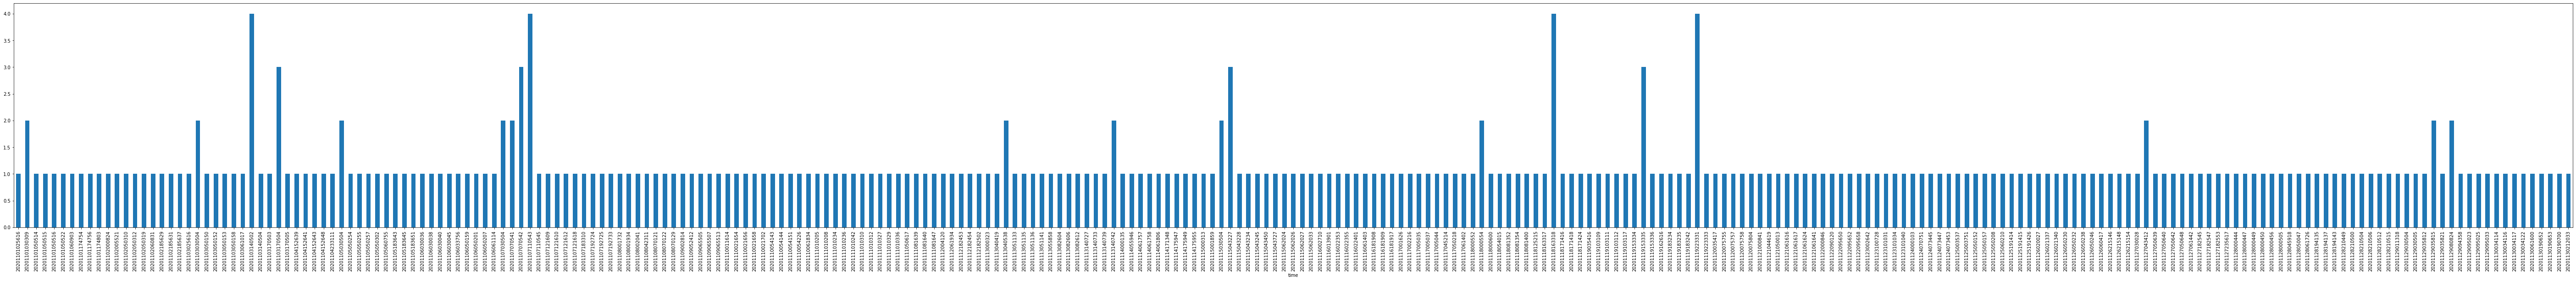

In [114]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(100,9))
df.groupby(df['time']).count()['errtype'].plot(kind = 'bar')

# plt.figure(df.groupby(df['time']).count()['errtype'].keys() , df.groupby(df['time']).count()['errtype'] )

In [271]:
# #list에 넣자. 12열씩 묶어서(time user_id fwver)을
# lst_lst = []
# for i in range(0,69052) :
  
#   df = train_quality[i*12:i*12+12]

#   lst = []
#   t = df.time.unique()
#   u = df.user_id.unique()
#   f = df.fwver.unique()
  
#   lst.append(t)
#   lst.append(u)
#   lst.append(f)

#   lst_lst.append(lst)
  
#   # train_quality[i*12:i*12+12]
#   # break

In [ ]:
train의 quality_3	quality_4	는 값이 모두 0이므로 쓸모 없음

In [ ]:
test_quality  = pd.read_csv(PATH+'test_quality_data.csv')

In [ ]:
test_quality.describe()

,time,user_id,quality_0,quality_2,quality_3,quality_4,quality_6,quality_11,quality_12
count,7.479720e+05,747972.000000,641388.000000,726857.000000,747972.0,747972.0,747972.000000,747972.000000,747972.000000
mean,2.020112e+13,37418.280005,2.062694,6.286763,0.0,0.0,2.118419,-0.186356,0.040558
std,8.818205e+06,4260.373568,218.919971,1199.262744,0.0,0.0,33.651757,0.401407,0.337775
min,2.020103e+13,30000.000000,-1.000000,-1.000000,0.0,0.0,-1.000000,-1.000000,0.000000
25%,2.020111e+13,33783.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,2.020112e+13,37296.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
75%,2.020112e+13,41081.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
max,2.020113e+13,44997.000000,93038.000000,636619.000000,0.0,0.0,600.000000,17.000000,19.000000


In [ ]:
test_quality.describe(include = "all")

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
count,7.479720e+05,747972.000000,725208,641388.000000,747961.0,726857.000000,747972.0,747972.0,747928,747972.000000,747972,747972.0,747972,747972,747972.000000,747972.000000
unique,NaN,NaN,22,NaN,44.0,NaN,NaN,NaN,3994,NaN,839,61.0,509,3515,NaN,NaN
top,NaN,NaN,05.15.2138,NaN,0.0,NaN,NaN,NaN,0,NaN,0,0.0,0,3,NaN,NaN
freq,NaN,NaN,142704,NaN,576597.0,NaN,NaN,NaN,399032,NaN,682584,645308.0,531700,98688,NaN,NaN
mean,2.020112e+13,37418.280005,NaN,2.062694,NaN,6.286763,0.0,0.0,NaN,2.118419,NaN,NaN,NaN,NaN,-0.186356,0.040558
std,8.818205e+06,4260.373568,NaN,218.919971,NaN,1199.262744,0.0,0.0,NaN,33.651757,NaN,NaN,NaN,NaN,0.401407,0.337775
min,2.020103e+13,30000.000000,NaN,-1.000000,NaN,-1.000000,0.0,0.0,NaN,-1.000000,NaN,NaN,NaN,NaN,-1.000000,0.000000
25%,2.020111e+13,33783.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,2.020112e+13,37296.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,2.020112e+13,41081.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000


In [ ]:
test_quality.dropna(axis=0).describe(include="all")

,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
count,6.397050e+05,639705.000000,639705,639705.000000,639705.0,639705.000000,639705.0,639705.0,639705,639705.000000,639705,639705.0,639705,639705,639705.000000,639705.000000
unique,NaN,NaN,20,NaN,34.0,NaN,NaN,NaN,3899,NaN,826,55.0,437,3450,NaN,NaN
top,NaN,NaN,05.15.2138,NaN,0.0,NaN,NaN,NaN,0,NaN,0,0.0,0,3,NaN,NaN
freq,NaN,NaN,142693,NaN,485988.0,NaN,NaN,NaN,319730,NaN,584035,546810.0,464491,92424,NaN,NaN
mean,2.020112e+13,37385.273360,NaN,1.834327,NaN,1.831522,0.0,0.0,NaN,2.434369,NaN,NaN,NaN,NaN,-0.196720,0.013664
std,8.827660e+06,4234.162415,NaN,210.339723,NaN,209.534635,0.0,0.0,NaN,36.106493,NaN,NaN,NaN,NaN,0.403569,0.273718
min,2.020103e+13,30000.000000,NaN,-1.000000,NaN,-1.000000,0.0,0.0,NaN,-1.000000,NaN,NaN,NaN,NaN,-1.000000,0.000000
25%,2.020111e+13,33817.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,2.020112e+13,37268.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,2.020112e+13,40939.000000,NaN,0.000000,NaN,0.000000,0.0,0.0,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000


In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')

In [ ]:
train_err

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1
16554659,24999,20201130172625,model_3,05.15.2138,16,1
16554660,24999,20201130172625,model_3,05.15.2138,4,0
16554661,24999,20201130172631,model_3,05.15.2138,4,0


#Errtype count로 Feature 42개 생성

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
id_error = train_err[['user_id','errtype']].values
error = np.zeros((15000,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 10000,err - 1] += 1

100%|██████████| 16554663/16554663 [00:45<00:00, 363664.18it/s]


In [ ]:
train_err.errcode.value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
3855                        1
7442                        1
6759                        1
3527                        1
5867                        1
Name: errcode, Length: 2805, dtype: int64

In [ ]:
train_err.shape

(16554663, 6)

##95%를 포함하는 에러코드 10개 선택 

In [ ]:
errcodes_selected = []
errcodes_selected_ratio = {}
count = 0 
value_count = train_err.errcode.value_counts()
for errcode in value_count.keys() : 
  count += value_count[errcode]
  if count/16554663 > 0.95 :
    break
  else : 
    errcodes_selected.append(errcode)
    errcodes_selected_ratio[errcode] = value_count[errcode]/16554663

In [ ]:
errcodes_selected_ratio

{'0': 0.15700247114664914,
 '1': 0.5380337249994156,
 '14': 0.01592161676743284,
 '2': 0.010050461311112162,
 '79': 0.020080263790329046,
 '80': 0.020176671672507016,
 '84': 0.007845282021144134,
 'B-A8002': 0.05423625959646536,
 'active': 0.013243277739933456,
 'connection timeout': 0.1108811456929084}

In [ ]:
len(errcodes_selected)

10

In [ ]:
errcodes_selected

['1',
 '0',
 'connection timeout',
 'B-A8002',
 '80',
 '79',
 '14',
 'active',
 '2',
 '84']

#ErrCode ratio(전체Errcode중)로  Feature 10개 생성

In [ ]:
id_ec = train_err[['user_id','errcode']].values
ecs = np.zeros((15000,10))
for person_idx, ec in tqdm(id_ec):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if ec in errcodes_selected : 
      ecs[ person_idx - 10000 , errcodes_selected.index(ec) ] = errcodes_selected_ratio[ec]

100%|██████████| 16554663/16554663 [00:27<00:00, 612985.24it/s]


In [ ]:
ecs.shape

(15000, 10)

추후 한 유저에서 일어난 비율을 곱해 줄 수도 있을듯

In [ ]:
# ratio로  Feature 10개 생성

# 한 USER에서 상위 10개 ErrCode의 비율로 feature 10개 생성 

In [ ]:
errcodes_selected

['1',
 '0',
 'connection timeout',
 'B-A8002',
 '80',
 '79',
 '14',
 'active',
 '2',
 '84']

In [ ]:
uec

'NFANDROID2'

In [ ]:
id_uec = train_err[['user_id','errcode']].values
uecs = np.zeros((15000,10))
pre_person_idx = 10000


def make_dict() : 
  dicts = [i for i in range(0,10)]
  for i in range(0,10) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, uec in tqdm(id_uec):
  if person_idx == pre_person_idx : 
    if uec in errcodes_selected : 
      dicts[ int(errcodes_selected.index(uec)) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,10) : 
      try : 
        uecs[pre_person_idx -10000, index] = dicts[index] / sum_dicts(dicts)
      except : 
        uecs[pre_person_idx -10000, index] = 0
    dicts = make_dict()
    pre_person_idx = person_idx
    if uec in errcodes_selected : 
      dicts[ int(errcodes_selected.index(uec)) ] +=1


100%|██████████| 16554663/16554663 [00:29<00:00, 564087.44it/s]


In [ ]:
uecs

array([[0.66876972, 0.32807571, 0.        , ..., 0.        , 0.00315457,
        0.        ],
       [0.76793249, 0.11030741, 0.        , ..., 0.07594937, 0.00421941,
        0.        ],
       [0.56393443, 0.43278689, 0.        , ..., 0.        , 0.00327869,
        0.        ],
       ...,
       [0.75600506, 0.18457649, 0.01643489, ..., 0.00505689, 0.02528445,
        0.        ],
       [0.82236842, 0.08552632, 0.        , ..., 0.00657895, 0.07894737,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# model_nm ratio(전체model_nm중)로 Feature 9개 생성

In [ ]:
model_nms_selected = []
model_nms_selected_ratio = {}
count = 0 
value_count = train_err.model_nm.value_counts()
for model_nm in value_count.keys() : 
  count += value_count[model_nm]
  # if count/16554663 > 0.95 :
  #   break
  # else : 
  model_nms_selected.append(model_nm)
  model_nms_selected_ratio[model_nm] = value_count[model_nm]/16554663

In [ ]:
model_nms_selected

['model_1',
 'model_0',
 'model_2',
 'model_3',
 'model_4',
 'model_8',
 'model_7',
 'model_5',
 'model_6']

In [ ]:
model_nms_selected_ratio

{'model_0': 0.2522720637683775,
 'model_1': 0.32525524681474943,
 'model_2': 0.2098051769462175,
 'model_3': 0.11522058769785891,
 'model_4': 0.09108019897475413,
 'model_5': 0.0019470647031594663,
 'model_6': 0.00010546877336011008,
 'model_7': 0.0021357124575716218,
 'model_8': 0.002178479863951323}

In [ ]:
id_mn = train_err[['user_id','model_nm']].values
mns = np.zeros((15000,9))
for person_idx, mn in tqdm(id_mn):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if mn in model_nms_selected : 
      mns[ person_idx - 10000 , model_nms_selected.index(mn) ] = model_nms_selected_ratio[mn]

100%|██████████| 16554663/16554663 [00:28<00:00, 584232.38it/s]


In [ ]:
mns.shape

(15000, 9)

#한 USER에서 model_nm의 비율로 feature 9개 생성

In [ ]:
train_err.model_nm.value_counts()

model_1    5384491
model_0    4176279
model_2    3473254
model_3    1907438
model_4    1507802
model_8      36064
model_7      35356
model_5      32233
model_6       1746
Name: model_nm, dtype: int64

In [ ]:
id_umn = train_err[['user_id','model_nm']].values
umns = np.zeros((15000,9))
pre_person_idx = 10000


def make_dict() : 
  dicts = [i for i in range(0,9)]
  for i in range(0,9) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, umn in tqdm(id_umn):
  if person_idx == pre_person_idx : 
    dicts[ int(umn.split("_")[1]) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,9) : 
      umns[pre_person_idx -10000, index] = dicts[index] / sum_dicts(dicts)
    dicts = make_dict()
    pre_person_idx = person_idx

    dicts[ int(umn.split("_")[1]) ] +=1


100%|██████████| 16554663/16554663 [00:30<00:00, 545983.83it/s]


#fwver ratio로 feature 7개 생성

In [ ]:
fwvers_selected = []
fwvers_selected_ratio = {}
count = 0 
value_count = train_err.fwver.value_counts()
for fwver in value_count.keys() : 
  count += value_count[fwver]
  if count/16554663 > 0.99 :
    break
  else : 
    fwvers_selected.append(fwver)
    fwvers_selected_ratio[fwver] = value_count[fwver]/16554663

In [ ]:
fwvers_selected_ratio

{'03.11.1167': 0.09095074904273195,
 '04.16.3553': 0.3163952053871468,
 '04.22.1750': 0.17361954151528183,
 '04.22.1778': 0.07816202601043586,
 '04.33.1185': 0.05821538016207276,
 '04.33.1261': 0.15130909037532206,
 '05.15.2138': 0.11516265840023443}

In [ ]:
fwvers_selected

['04.16.3553',
 '04.22.1750',
 '04.33.1261',
 '05.15.2138',
 '03.11.1167',
 '04.22.1778',
 '04.33.1185']

In [ ]:
id_fwver = train_err[['user_id','fwver']].values
fwvers = np.zeros((15000,7))
for person_idx, fwver in tqdm(id_fwver):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if fwver in fwvers_selected : 
      fwvers[ person_idx - 10000 , fwvers_selected.index(fwver) ] = fwvers_selected_ratio[fwver]

100%|██████████| 16554663/16554663 [00:29<00:00, 567731.17it/s]


#한 USER에서 fwver의 비율로 feature 7개 생성

In [ ]:
id_ufwver = train_err[['user_id','fwver']].values
ufwvers = np.zeros((15000,7))
pre_person_idx = 10000


def make_dict() : 
  dicts = [i for i in range(0,7)]
  for i in range(0,7) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, ufwver in tqdm(id_ufwver):
  if person_idx == pre_person_idx : 
    if ufwver in fwvers_selected : 
      dicts[ int(fwvers_selected.index(ufwver)) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,7) : 
      try : 
        ufwvers[pre_person_idx -10000, index] = dicts[index] / sum_dicts(dicts)
      except : 
        ufwvers[pre_person_idx -10000, index] = 0
    dicts = make_dict()
    pre_person_idx = person_idx
    if ufwver in fwvers_selected : 
      dicts[ int(fwvers_selected.index(ufwver)) ] +=1


100%|██████████| 16554663/16554663 [00:30<00:00, 549538.45it/s]


In [ ]:
ufwvers

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.8397463, ..., 0.       , 0.       ,
        0.1602537],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.562954 , 0.       , ..., 0.       , 0.437046 ,
        0.       ],
       [0.       , 0.0516129, 0.       , ..., 0.       , 0.9483871,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

#errtyp4, 31 여부

In [ ]:
id_error = train_err[['user_id','errtype']].values
et_4_31 = np.zeros((15000,2))
for person_idx, err in tqdm(id_error):
  if err == 4 : 
    et_4_31[person_idx - 10000, 0] = 1
  elif err == 31:
    et_4_31[person_idx - 10000, 1] = 1


100%|██████████| 16554663/16554663 [00:31<00:00, 518572.03it/s]


In [ ]:
et_4_31

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 1.],
       [0., 1.],
       [1., 0.]])

In [ ]:
#각 errtype과 errcode의 조합이 일어난 횟수 추가

#각 errtype과 errcode의 조합이 일어난 횟수 추가

In [ ]:
train_err.errcode.value_counts()

1                     8906967
0                     2599123
connection timeout    1835600
B-A8002                897863
80                     334018
                       ...   
5465                        1
35370                       1
21140                       1
7626                        1
8840                        1
Name: errcode, Length: 2805, dtype: int64

In [ ]:
sum(train_err.errcode.value_counts())

16554662

In [ ]:
errcodes_selected = []
count = 0 
for errcode in train_err.errcode.value_counts().keys() : 
  count += train_err.errcode.value_counts()[errcode]
  if count/16554662 > 0.9 :
    break
  else : 
    errcodes_selected.append(errcode)

In [ ]:
errcodes_selected.append('remainder')

In [ ]:
combi_err_code_type = []
for errtype in sorted(train_err.errtype.unique()) : 
  for errcode in errcodes_selected : 
    combi_err_code_type.append(str(errtype) + "_" + str(errcode))

In [ ]:
train_err  = pd.read_csv(PATH+'train_err_data.csv')
id_ey_ec = train_err[['user_id','errtype','errcode']].values

In [ ]:
ey_ec = np.zeros((15000,246))
for person_idx, ey, ec in tqdm(id_ey_ec):
    # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if ec in ['1', '0', 'connection timeout', 'B-A8002', '80'] : 
      col = str(ey)+'_'+ec
    else : 
      col = str(ey) + '_'+'remainder'
    index_col = combi_err_code_type.index(col)

    ey_ec[person_idx - 10000,index_col] += 1


100%|██████████| 16554663/16554663 [01:20<00:00, 204871.10it/s]


In [ ]:
ey_ec.shape

(15000, 246)

#모든 피쳐 join하여 학습시키기

In [ ]:
train = np.concatenate( (error,ecs, mns,fwvers ,et_4_31,ey_ec) , axis=1)

In [ ]:
# train = pd.DataFrame(np.concatenate( (error,ecs, mns,fwvers ,et_4_31) , axis=1))
train = pd.DataFrame(np.concatenate( (error,ecs,uecs,mns,umns,fwvers,ufwvers,et_4_31) , axis=1))


train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

train['problem'] = problem
from pycaret.classification import *
clf = setup(data = train, target = 'problem') 

,Description,Value
0,session_id,8077
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 97)"
5,Missing Values,False
6,Numeric Features,67
7,Categorical Features,29
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_5 = compare_models(sort = 'AUC', n_select = 5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7927,0.8120,0.5056,0.7925,0.6171,0.4844,0.5075,8.856
lightgbm,Light Gradient Boosting Machine,0.7930,0.8101,0.5189,0.7824,0.6236,0.4888,0.5087,0.253
gbc,Gradient Boosting Classifier,0.7923,0.8096,0.4820,0.8142,0.6052,0.4765,0.5069,2.156
rf,Random Forest Classifier,0.7901,0.8052,0.4906,0.7964,0.6070,0.4746,0.5006,1.149
et,Extra Trees Classifier,0.7870,0.7974,0.4938,0.7816,0.6050,0.4692,0.4925,0.861
ada,Ada Boost Classifier,0.7794,0.7952,0.4765,0.7681,0.5879,0.4484,0.4724,0.534
xgboost,Extreme Gradient Boosting,0.7792,0.7909,0.5218,0.7338,0.6096,0.4618,0.4750,27.806
lda,Linear Discriminant Analysis,0.7665,0.7670,0.3661,0.8341,0.5086,0.3847,0.4409,0.098
lr,Logistic Regression,0.7474,0.7570,0.3543,0.7497,0.4806,0.3411,0.3831,1.165
nb,Naive Bayes,0.7158,0.7194,0.2387,0.7075,0.3558,0.2279,0.2835,0.028


In [ ]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8043,0.8175,0.5101,0.8329,0.6327,0.5096,0.5381
1,0.7967,0.8303,0.4827,0.8313,0.6108,0.4859,0.5188
2,0.7857,0.7907,0.5014,0.7699,0.6073,0.4689,0.4893
3,0.7938,0.8100,0.4813,0.8206,0.6067,0.4796,0.5109
4,0.7966,0.8185,0.5022,0.8093,0.6198,0.4911,0.5172
Mean,0.7954,0.8134,0.4955,0.8128,0.6155,0.4870,0.5148
SD,0.0060,0.0131,0.0115,0.0231,0.0098,0.0135,0.0157


In [ ]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7843,0.8154,0.4651,0.8241,0.5946,0.4627,0.4979


In [ ]:
final_model = finalize_model(blended)

#테스트셋 만들기

In [ ]:
test_err  = pd.read_csv(PATH+'test_err_data.csv')
id_error = test_err[['user_id','errtype']].values
error = np.zeros((14999,42))
for person_idx, err in tqdm(id_error):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    error[person_idx - 30000,err - 1] += 1

# errcodes_selected = []
errcodes_selected_ratio = {}
# count = 0 
value_count = test_err.errcode.value_counts()
for errcode in errcodes_selected : 
  # count += value_count[errcode]
  # if count/16532648 > 0.95 :
  #   break
  # else : 
  # errcodes_selected.append(errcode)
  errcodes_selected_ratio[errcode] = value_count[errcode]/16532648

id_ec = test_err[['user_id','errcode']].values
ecs = np.zeros((14999,10))
for person_idx, ec in tqdm(id_ec):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if ec in errcodes_selected : 
      ecs[ person_idx - 30000 , errcodes_selected.index(ec) ] = errcodes_selected_ratio[ec]


id_uec = test_err[['user_id','errcode']].values
uecs = np.zeros((14999,10))
pre_person_idx = 30000


def make_dict() : 
  dicts = [i for i in range(0,10)]
  for i in range(0,10) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, uec in tqdm(id_uec):
  if person_idx == pre_person_idx : 
    if uec in errcodes_selected : 
      dicts[ int(errcodes_selected.index(uec)) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,10) : 
      try : 
        uecs[pre_person_idx -30000, index] = dicts[index] / sum_dicts(dicts)
      except : 
        uecs[pre_person_idx -30000, index] = 0
    dicts = make_dict()
    pre_person_idx = person_idx
    if uec in errcodes_selected : 
      dicts[ int(errcodes_selected.index(uec)) ] +=1


id_mn = test_err[['user_id','model_nm']].values
mns = np.zeros((14999,9))
for person_idx, mn in tqdm(id_mn):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if mn in model_nms_selected : 
      mns[ person_idx - 30000 , model_nms_selected.index(mn) ] = model_nms_selected_ratio[mn]


id_umn = test_err[['user_id','model_nm']].values
umns = np.zeros((14999,9))
pre_person_idx = 30000


def make_dict() : 
  dicts = [i for i in range(0,9)]
  for i in range(0,9) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, umn in tqdm(id_umn):
  if person_idx == pre_person_idx : 
    dicts[ int(umn.split("_")[1]) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,9) : 
      umns[pre_person_idx -30000, index] = dicts[index] / sum_dicts(dicts)
    dicts = make_dict()
    pre_person_idx = person_idx

    dicts[ int(umn.split("_")[1]) ] +=1


# fwvers_selected = []
fwvers_selected_ratio = {}
# count = 0 
value_count = test_err.fwver.value_counts()
for fwver in fwvers_selected : 
  # count += value_count[fwver]
  # if count/16532648 > 0.99 :
  #   break
  # else : 
    # fwvers_selected.append(fwver)
  fwvers_selected_ratio[fwver] = value_count[fwver]/16532648


id_fwver = test_err[['user_id','fwver']].values
fwvers = np.zeros((14999,7))
for person_idx, fwver in tqdm(id_fwver):
    # person_idx - 30000 위치에 person_idx, errtype에 해당하는 error값을 +1
    if fwver in fwvers_selected : 
      fwvers[ person_idx - 30000 , fwvers_selected.index(fwver) ] = fwvers_selected_ratio[fwver]


id_ufwver = test_err[['user_id','fwver']].values
ufwvers = np.zeros((14999,7))
pre_person_idx = 30000


def make_dict() : 
  dicts = [i for i in range(0,7)]
  for i in range(0,7) : 
    dicts[i] = 0
  return dicts
  
def sum_dicts(dicts) :
  sum = 0
  for i in dicts : 
    sum+= i 
  return sum


dicts = make_dict()

for person_idx, ufwver in tqdm(id_ufwver):
  if person_idx == pre_person_idx : 
    if ufwver in fwvers_selected : 
      dicts[ int(fwvers_selected.index(ufwver)) ] +=1
  else : 
    # print(pre_person_idx, person_idx, dicts)
    
    for index in range(0,7) : 
      try : 
        ufwvers[pre_person_idx -30000, index] = dicts[index] / sum_dicts(dicts)
      except : 
        ufwvers[pre_person_idx -30000, index] = 0
    dicts = make_dict()
    pre_person_idx = person_idx
    if ufwver in fwvers_selected : 
      dicts[ int(fwvers_selected.index(ufwver)) ] +=1



id_error = test_err[['user_id','errtype']].values
et_4_31 = np.zeros((14999,2))
for person_idx, err in tqdm(id_error):
  if err == 4 : 
    et_4_31[person_idx - 30000, 0] = 1
  elif err == 31:
    et_4_31[person_idx - 30000, 1] = 1

test = np.concatenate( (error,ecs, mns,fwvers ,et_4_31) , axis=1)

100%|██████████| 16532648/16532648 [00:30<00:00, 542717.04it/s]


In [ ]:
test = pd.DataFrame(np.concatenate( (error,ecs,uecs,mns,umns,fwvers,ufwvers,et_4_31) , axis=1))

In [ ]:
predictions = predict_model(final_model, data = test)

In [ ]:
predictions

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,Label,Score
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,3.0,67.0,37.0,9.0,3.0,0.0,1.0,0.0,983.0,1308.0,5.0,2.0,32.0,0.0,0.0,0.0,0.0,83.0,2.0,16.0,0.0,1.0,3.0,3.0,0.0,2.0,92.0,...,0.005238,0.052750,0.005612,0.000374,0.325255,0.000000,0.209805,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.977091,0.022909,0.0,0.0,0.0,0.0,0.0,0.0,0.322158,0.000000,0.1577,0.000000,0.0,0.000000,0.0,0.973563,0.000000,0.026437,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.9476
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,12.0,16.0,4.0,6.0,53.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.010676,0.000000,0.000000,0.000000,0.000000,0.115221,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.108879,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.7743
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,16.0,16.0,0.0,1.0,173.0,133.0,0.0,0.0,0.0,0.0,0.0,60.0,40.0,2.0,0.0,40.0,0.0,0.0,0.0,0.0,230.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,14.0,113.0,...,0.004315,0.007551,0.014024,0.000000,0.000000,0.252272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.179623,0.0000,0.000000,0.0,0.082762,0.0,0.000000,0.778959,0.000000,0.0,0.0,0.221041,0.0,0.0,1.0,0.0,0.7281
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,4.0,5.0,1.0,7.0,8.0,12.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,0.0,0.0,5.0,2.0,2.0,0.0,0.0,134.0,0.0,4.0,16.0,3.0,1.0,1.0,0.0,0.0,40.0,...,0.030726,0.002793,0.002793,0.000000,0.000000,0.252272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.179623,0.0000,0.000000,0.0,0.082762,0.0,0.000000,0.663073,0.000000,0.0,0.0,0.336927,0.0,0.0,1.0,1.0,0.8217
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,10.0,12.0,1.0,18.0,80.0,67.0,6.0,0.0,0.0,0.0,0.0,10.0,8.0,0.0,0.0,14.0,1.0,1.0,0.0,0.0,332.0,152.0,11.0,6.0,1.0,1.0,1.0,1.0,0.0,48.0,...,0.032383,0.006477,0.005181,0.002591,0.325255,0.000000,0.209805,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.707151,0.292849,0.0,0.0,0.0,0.0,0.0,0.0,0.322158,0.000000,0.1577,0.000000,0.0,0.000000,0.0,0.709567,0.000000,0.290433,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.8961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,16.0,19.0,3.0,9.0,123.0,93.0,12.0,0.0,0.0,0.0,0.0,197.0,204.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,179.0,2.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,0.025974,0.000000,0.013986,0.000000,0.325255,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.322158,0.000000,0.0000,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.6827
14995,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,14.0,15.0,1.0,4.0,149.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,183.0,0.0,14.0,1.0,0.0,1.0,1.0,0.0,0.0,12.0,...,0.012146,0.000000,0.026316,0.000000,0.000000,0.252272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.179623,0.0000,0.000000,0.0,0.082762,0.0,0.000000,0.079612,0.000000,0.0,0.0,0.920388,0.0,0.0,1.0,0.0,0.7625
14996,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,12.0,13.0,1.0,3.0,129.0,90.0,2.0,0.0,0.0,0.0,0.0,138.0,165.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,163.0,0.0,12.0,1118.0,0.0,1.0,1.0,1.0,0.0,329.0,...,0.002454,0.063804,0.324540,0.000000,0.000000,0.252272,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.179623,0.0000,0.000000,0.0,0.082762,0.0,0.000000,0

In [ ]:
#pycaret prediction에서 Label은 '0', '1', 'Score'은 Label을 맞출 확률이기
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    x.append(1-predictions['Score'][i])

In [ ]:
x

[0.9476,
 0.2257,
 0.27190000000000003,
 0.8217,
 0.8961,
 0.4033,
 0.12339999999999995,
 0.05559999999999998,
 0.6457,
 0.2621,
 0.14700000000000002,
 0.1422,
 0.9257,
 0.1099,
 0.18179999999999996,
 0.2813,
 0.3386,
 0.42579999999999996,
 0.3437,
 0.3086,
 0.9124,
 0.5441,
 0.17269999999999996,
 0.12629999999999997,
 0.5287,
 0.27980000000000005,
 0.28459999999999996,
 0.11880000000000002,
 0.15259999999999996,
 0.08020000000000005,
 0.14749999999999996,
 0.7245,
 0.134,
 0.2015,
 0.36060000000000003,
 0.2921,
 0.10699999999999998,
 0.397,
 0.23640000000000005,
 0.10040000000000004,
 0.36,
 0.11209999999999998,
 0.10009999999999997,
 0.09189999999999998,
 0.16400000000000003,
 0.24919999999999998,
 0.29169999999999996,
 0.1159,
 0.3012,
 0.15059999999999996,
 0.1975,
 0.3227,
 0.33819999999999995,
 0.10770000000000002,
 0.04349999999999998,
 0.19530000000000003,
 0.3659,
 0.3025,
 0.42669999999999997,
 0.20179999999999998,
 0.46440000000000003,
 0.9506,
 0.8594,
 0.03639999999999999,

In [ ]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("96features.csv", index = False)